<a href="https://colab.research.google.com/github/cuhkrsdi/newspaper-analytics/blob/main/Visualization%2C_wordcloud_graph_(Public).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualize NLP result with frequency chart and word cloud

- Read the result of named-entity recognition
- prepare function which used the manually built filters to extract the valid result
- display word occurrence with frequency charts and word clouds

###Import libraries

In [1]:
# retrieve data
import json
from urllib.request import urlopen

# Ignore SSL for url demo
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# frequency charts
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# word clouds
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

# color schemes for word cloud 
import random
from palettable.colorbrewer.sequential import YlGnBu_9, BuPu_9, YlOrRd_9, PuBuGn_9, GnBu_9 # 5 sets of colors

###Read the result and filters

In [2]:
# Here the result shares EXACTLY THE SAME structure as the sample demo in the "data_preprocessing_and_NLP (Public).ipynb", the only difference is the total amount of data
# read result
url_result = "https://dsprojects.lib.cuhk.edu.hk/media/filer_public/ea/69/ea69bab5-552f-4dd3-a5ef-02aa79faa7a7/ymd_frequency001.json"
result_file = urlopen(url_result)
ymd_freq_dict = json.loads(result_file.read().decode("utf-8"))

In [3]:
# Structure:    ymd_freq_dict = {ymd: {word: {type1: freq, type2:freq, ...}, word: {...}}, ymd: {...}}
print(len(ymd_freq_dict.keys()))

3250


In [4]:
# read filters, expect: 'PERSON_list', 'PERSON_dict', 'ORG_list', 'ORG_dict', 'EVENT_list', 'EVENT_dict', 'ymd_to_pid_dict', 'pid_to_parent', 'GPE_dict', 'GPE_list'
url_filterdict = "https://dsprojects.lib.cuhk.edu.hk/media/filer_public/f6/71/f671a0da-1533-409a-a014-ec31d4aeac1c/filteranddict.json" 
filter_file = urlopen(url_filterdict)
dict_list_filters = json.loads(filter_file.read().decode("utf-8"))

In [5]:
# Structure:    dict_list_filters = {'list_name': [...], 'dict_name': {...}}
print(dict_list_filters.keys())

dict_keys(['PERSON_list', 'PERSON_dict', 'ORG_list', 'ORG_dict', 'EVENT_list', 'EVENT_dict', 'ymd_to_pid_dict', 'pid_to_parent', 'GPE_dict', 'GPE_list'])


###Define function for filtering

In [6]:
# Input: str of NER type, pre-made inclusion filter of the NER type, pre-made replacement filter of the NER type, nested dictionary of NLP result
# Output: dictionary of word: frequency of occurrence

def filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict):

  temp_type_gpe_dict = dict()

  filter_list = dict_list_filters[filter_inclusion]
  filter_dict = dict_list_filters[filter_replacement]

  # for each loops
  for ymd_key in ymd_freq_dict.keys():
    for ner_word in ymd_freq_dict[ymd_key].keys():
      for ner_type in ymd_freq_dict[ymd_key][ner_word].keys():

        # check validity 1) Type 2) ner_word exist in filter list
        if (ner_type == type_to_filter) and (ner_word in filter_list):

          if ner_word not in filter_dict:
            if ner_word not in temp_type_gpe_dict:
              temp_type_gpe_dict[ner_word] = ymd_freq_dict[ymd_key][ner_word][ner_type]
            else:
              temp_type_gpe_dict[ner_word] = temp_type_gpe_dict.get(ner_word, None) + ymd_freq_dict[ymd_key][ner_word][ner_type]

          else: # ner_word in filter_dict:
            corrected_ner_word = filter_dict[ner_word]
            if corrected_ner_word not in temp_type_gpe_dict:
              temp_type_gpe_dict[corrected_ner_word] = ymd_freq_dict[ymd_key][ner_word][ner_type]
            else:
              temp_type_gpe_dict[corrected_ner_word] = temp_type_gpe_dict.get(corrected_ner_word, None) + ymd_freq_dict[ymd_key][ner_word][ner_type]
              
  return temp_type_gpe_dict

###Download Fonts for Traditional Chinese characters

In [7]:
# Download the Font for Traditional Chinese characters
!wget "https://github.com/cuhkrsdi/newspaper-analytics/raw/main/NotoSansTC-Regular.otf"

--2022-08-05 04:18:15--  https://github.com/cuhkrsdi/newspaper-analytics/raw/main/NotoSansTC-Regular.otf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cuhkrsdi/newspaper-analytics/main/NotoSansTC-Regular.otf [following]
--2022-08-05 04:18:15--  https://raw.githubusercontent.com/cuhkrsdi/newspaper-analytics/main/NotoSansTC-Regular.otf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5766468 (5.5M) [application/octet-stream]
Saving to: ‘NotoSansTC-Regular.otf’

NotoSansTC-Regular. 100%[===================>]   5.50M  --.-KB/s    in 0.1s    

2022-08-05 04:18:16 (44.4 MB/s) - ‘NotoSansTC-Regular.ot

###Frequency chart - PERSON

In [8]:
"""
# From:
# ymd_freq_dict = {ymd: {word: {ner_type: freq, ner_type: freq, ...}}}

# To: freq of all PERSON type
# temp_type_gpe_dict = {ner_word: freq, ner_word: freq}
"""

# MODIFY Before Run!!!!!!!!
# Selected Type
type_to_filter = "PERSON"
# Selected Filter
filter_inclusion = 'PERSON_list'
filter_replacement = 'PERSON_dict'
        
temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)


In [9]:
# organize dictionary by frequency of occurrencefrom highest and turn into dataframe
ordered_dict = OrderedDict(sorted(temp_type_gpe_dict.items(), key=lambda t: -t[1]))
df = pd.DataFrame(list(ordered_dict.items()))
df.columns = [type_to_filter, 'occurrence']
# pd.set_option('display.max_rows', None)
df

PERSON  occurrence
0      毛澤東        6910
1      陳孝威        4500
2      尼克遜        3784
3     赫魯歇夫        2303
4      艾森豪        1940
..     ...         ...
827     凌雲          22
828     胡璉          22
829    陳質平          22
830     宇垣          22
831    王映霞          22

[832 rows x 2 columns]

In [10]:
pd.set_option('display.max_rows', None)
df

PERSON  occurrence
0       毛澤東        6910
1       陳孝威        4500
2       尼克遜        3784
3      赫魯歇夫        2303
4       艾森豪        1940
5        林彪        1860
6       周恩來        1579
7       史大林        1435
8       何濟公        1361
9       邱吉爾        1174
10      劉少奇        1056
11      甘迺迪        1008
12      杜魯門         963
13      戴高樂         949
14      杜爾斯         917
15      李承晚         904
16      李世民         796
17      希特勒         761
18       狄托         742
19      李宗仁         731
20       雷根         724
21      胡志明         709
22       中山         673
23      尼赫魯         650
24      吳廷琰         634
25      王世昭         631
26      鄧小平         623
27      袁世凱         606
28       孔子         584
29      韋千里         550
30       麥帥         527
31       上帝         516
32       蔣公         509
33     麥克阿瑟         508
34      蘇加諾         502
35       艾登         491
36      羅邱杜         482
37      朱可夫         481
38       陳毅         474
39      張作霖         471
40      羅斯福         468
41       吉田         456
42      史太林         454
43      孫中山         439
44      朴正熙         415
45       老赫         412
46      馬歇爾         396
47       甘地         395
48       江青         392
49     卡斯特羅         386
50      張學良         380
51       老毛         371
52      汪精衛         366
53       邱翁         365
54       胡適         353
55      杜月笙         352
56     莫洛托夫         343
57      曹汝霖         340
58      魯斯克         338
59      蔣經國         337
60      基辛格         327
61       朱德         320
62      金日成         302
63       列寧         301
64       古月         292
65       佐藤         289
66      于右任         282
67      黎元洪         274
68      李鴻章         273
69       朱子         264
70      威爾遜         263
71      段祺瑞         262
72       基督         262
73      阿登諾         261
74       曹操         258
75      阮文紹         258
76       孟子         255
77      李光耀         255
78       陳誠         253
79      袁樹珊         251
80       邁一         250
81       耶穌         247
82       李白         246
83       魯迅         243
84      李奇威         243
85      克拉克         243
86      張宗昌         240
87      毛泽東         237
88      史達林         235
89      陳立夫         234
90      黄旭初         233
91      郭沫若         232
92       田中         225
93       秀蘭         221
94      社魯門         220
95       拉曼         220
96      段宏俊         219
97      馮玉祥         217
98      章太炎         217
99      蔣介石         213
100     左舜生         212
101      裴航         211
102      岳飛         210
103     吉田茂         204
104     金典戎         204
105     張世明         199
106      納薩         199
107     張大千         198
108      劉邦         197
109     毛泽东         192
110     沈昌煥         190
111     臧勺波         190
112   艾森豪威爾         189
113     余叔岩         188
114     馬可斯         188
115     毛邦初         184
116     黃旭初         184
117     胡宗南         184
118     周佛海         180
119      鳩山         180
120     毛主席         179
121      林黛         179
122      李彌         178
123      毛澤         173
124     胥端甫         172
125     李宗黄         164
126     尹望卿         162
127     葉公超         161
128    葛羅米柯         161
129     陶百川         160
130     高玉樹         160
131     王世杰         158
132     胡漢民         156
133     宋子文         155
134     艾契遜         152
135      孫科         152
136      秦檜         150
137     胡秋原         149
138     梁任公         147
139     赫爾利         147
140     馬思聰         147
141     易君左         145
142     袁世凯         144
143     李宗黃         144
144     希特拉         141
145     尹仲容         141
146     潘佩珠         138
147      李淵         138
148     陳作藩         136
149      元陽         136
150     馬克斯         135
151     張其昀         135
152      詹淼         135
153     哈里曼         134
154     何應欽         134
155     唐太宗         132
156     龔德柏         132
157      于斌         131
158      杜甫         131
159      羅拔         131
160     梅蘭芳         130
161      康生         128
162    赫魯曉夫         127
163    達賴喇嘛         126
164     孫立人         125
165     周至柔         1

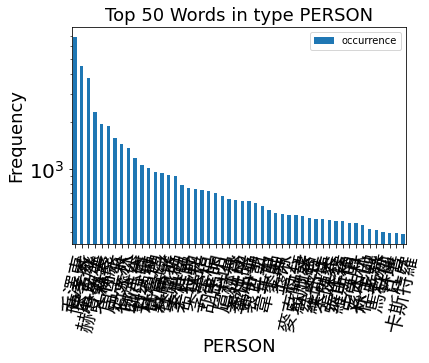

In [11]:
from matplotlib.ticker import ScalarFormatter
# Load font
fprop = fm.FontProperties(fname='/content/NotoSansTC-Regular.otf') 

# modift the length of chart
length = 50

df_sliced = df[0 :length]

df_sliced.plot.bar(x=type_to_filter, y="occurrence", rot=77, logy=True) # logy
plt.title('Top 50 Words in type PERSON', fontsize=18)

xticks = list(df_sliced[type_to_filter])
x = [i for i in range(length)]
plt.xticks(x, xticks, fontproperties=fprop, fontsize=20) # rotation ='vertical'
plt.yticks(fontsize=20, rotation ='horizontal')
plt.xlabel('PERSON', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
#plt.yscale('log')

# plt.figure(figsize=(8, 2))
plt.rcParams["figure.figsize"] = (25,25)
plt.show(block=True)

###Frequency chart - ORG

In [12]:
"""
# From:
# ymd_freq_dict = {ymd: {word: {ner_type: freq, ner_type: freq, ...}}}

# To: freq of all ORG type
# temp_type_gpe_dict = {ner_word: freq, ner_word: freq}
"""

# MODIFY Before Run!!!!!!!!
# Selected Type
type_to_filter = "ORG"
# Selected Filter
filter_inclusion = 'ORG_list'
filter_replacement = 'ORG_dict'


temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

In [13]:
# organize dictionary by frequency of occurrencefrom highest and turn into dataframe
ordered_dict = OrderedDict(sorted(temp_type_gpe_dict.items(), key=lambda t: -t[1]))
df = pd.DataFrame(list(ordered_dict.items()))
df.columns = [type_to_filter, 'occurrence']
df

ORG  occurrence
0               中共       64925
1               共黨       10278
2               毛共        7983
3               反共        6335
4               越共        4112
5              行政院        3469
6               俄共        3349
7              聯合國        3165
8               美軍        2370
9              立法院        2251
10             共產黨        2018
11             國民黨        1657
12              中央        1359
13              白宮        1335
14              國會        1325
15              共軍        1251
16             民主黨        1243
17              華府        1078
18             共和黨        1052
19           聯興書報社         940
20           香港天文台         902
21              日共         891
22             外交部         752
23             監察院         729
24            國民政府         727
25              越盟         724
26              蘇共         687
27              日軍         682
28             教育部         641
29              政府         581
30             天文台         581
31              工黨         570
32             國務院         542
33             保守黨         487
34              國軍         476
35              美网         465
36              寮共         425
37              北約         407
38              立院         388
39              北大         385
40              國大         381
41              北越         377
42              美國         376
43           春秋出版社         374
44            國民大會         353
45             財政部         341
46           大千書報店         340
47            人民日報         335
48              國共         333
49        僑友股份有限公司         333
50            中央銀行         330
51            台灣銀行         327
52           克里姆林宮         321
53             僑委會         310
54              納粹         307
55             中共軍         299
56             天主教         298
57              台大         273
58         越南聯興書報社         273
59             經濟部         268
60             安理會         263
61            天文台報         262
62           僑務委員會         260
63              蘇軍         259
64             內政部         256
65              紅軍         254
66              抗共         254
67          太平洋鼓吹集         252
68              德軍         248
69             交通部         238
70             自民黨         236
71             總統府         230
72              英軍         219
73             社會黨         218
74              清廷         214
75             新華社         210
76             内政部         209
77            國防部長         205
78              南中         203
79              佛教         201
80            共黨集團         200
81              印共         199
82              俄軍         199
83             美聯社         197
84          泰國總代理處         196
85            中央政府         194
86              美共         193
87              海軍         184
88             司法院         184
89             青年黨         183
90             中央社         176
91             好萊塢         170
92            第七艦隊         167
93              韓共         166
94           中央研究院         165
95            紐約時報         165
96              馬共         165
97            國際共黨         164
98             基督教         162
99             立法委         162
100             法軍         158
101           中央日報         154
102        香港天文台報社         154
103            南越軍         150
104            參議院         149
105            政治局         148
106          天文台報社         147
107             法共         146
108             緬共         145
109           中央黨部         144
110             港共         143
111            板門店         142
112            解放軍         141
113           美國務院         141
114             泰共         141
115            新聞局         141
116          寮國經銷處         139
117            華僑社         139
118             日寇         138
119            毛林派         138
120           最高法院         136
121            立法局         133
122            湘淮軍         132
123          中央情報局         128
124             奉軍         126
125          中央委員會         124
126            東南盟         123
127             陸軍         120
128          台北市

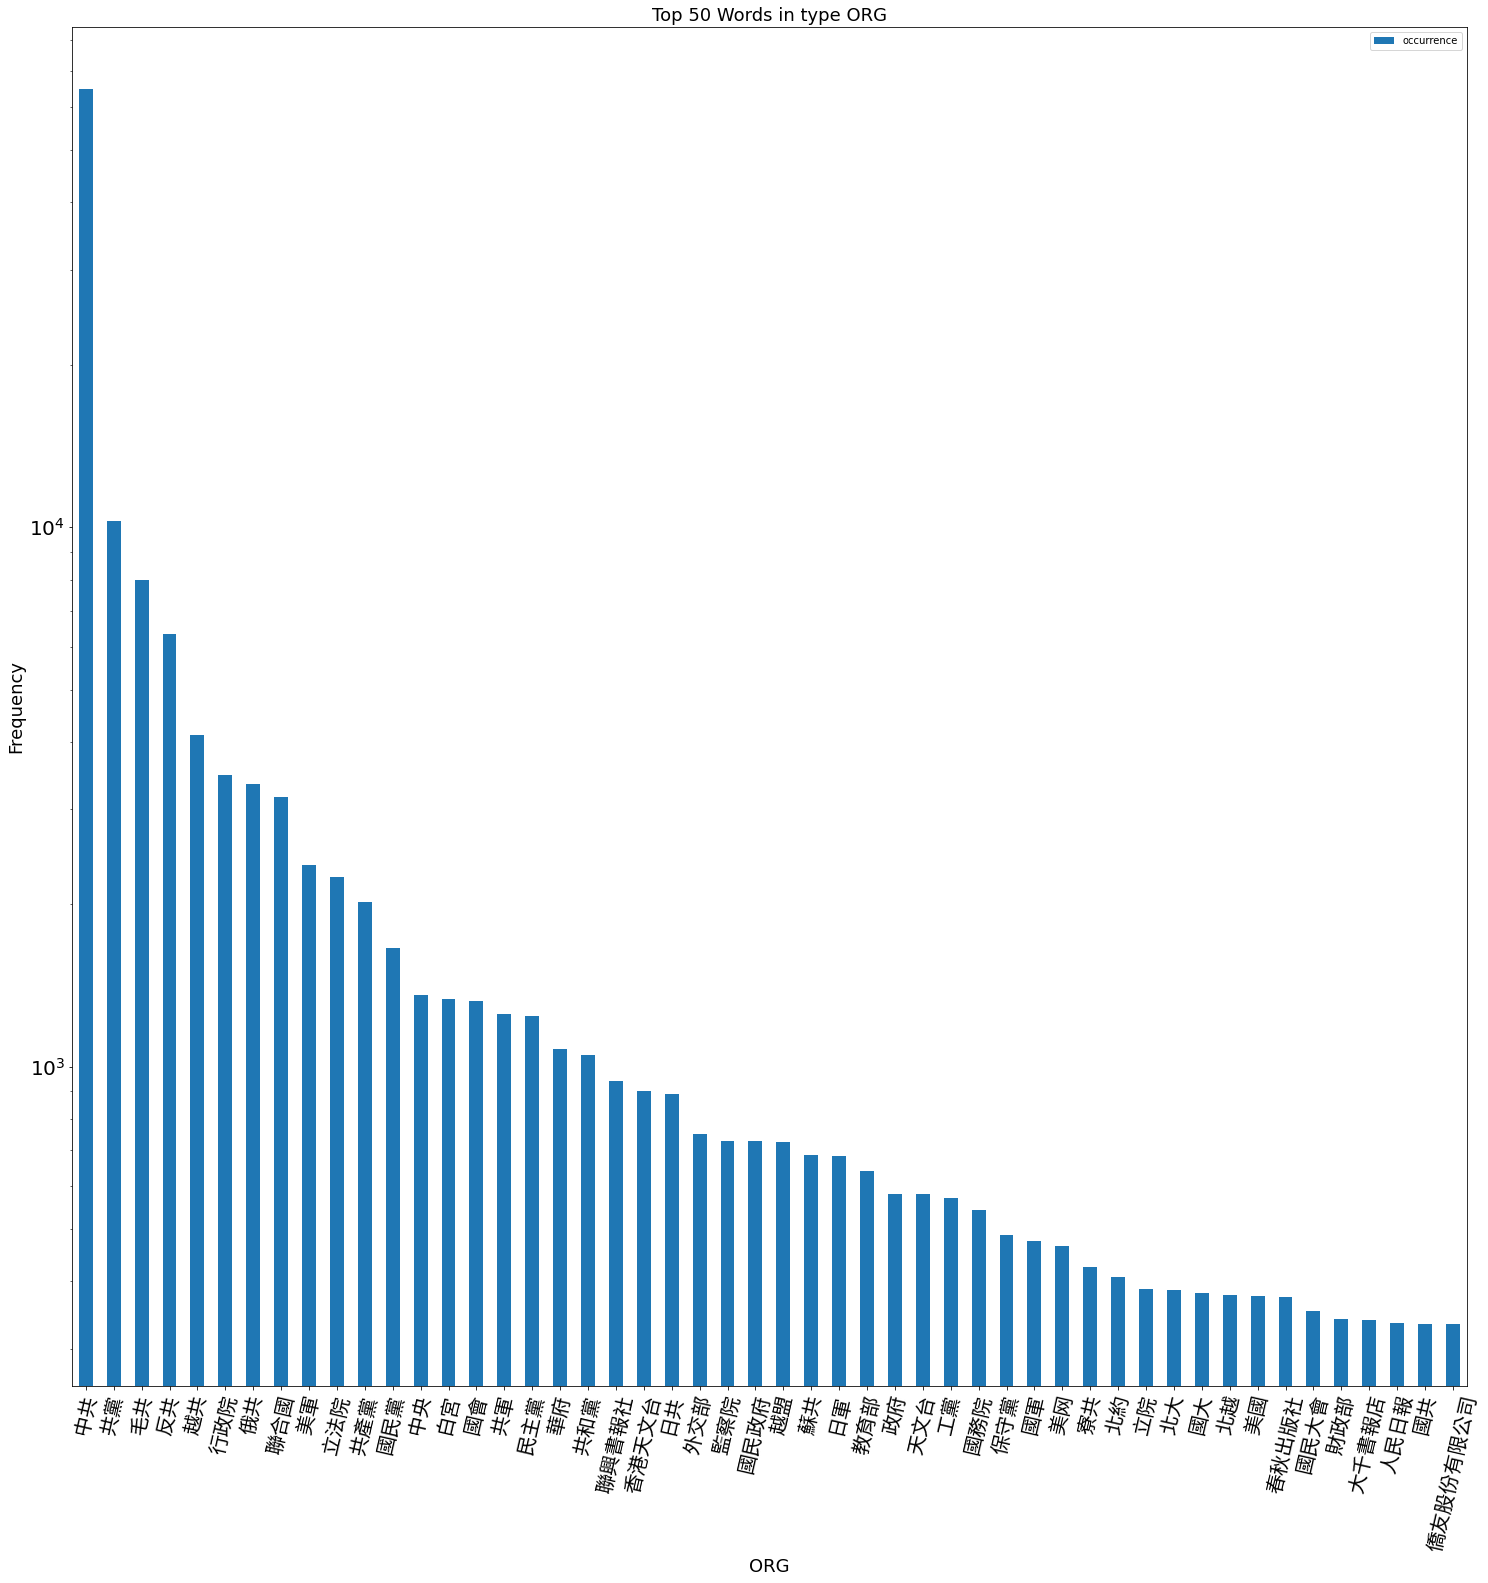

In [14]:
fprop = fm.FontProperties(fname='/content/NotoSansTC-Regular.otf') # from installed path 

# modify the length of chart
length = 50

df_sliced = df[0:length]

df_sliced.plot.bar(x=type_to_filter, y="occurrence", rot=77, logy=True) 
plt.title('Top 50 Words in type ORG', fontsize=18)


xticks = list(df_sliced[type_to_filter])
x = [i for i in range(length)]
plt.xticks(x, xticks, fontproperties=fprop, fontsize=20) # rotation ='vertical'
plt.yticks(fontsize = 20, rotation ='horizontal')
plt.xlabel('ORG', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# plt.figure(figsize=(8, 2))
plt.rcParams["figure.figsize"] = (25,25)
plt.show(block=True)


###Frequency chart - EVENT

In [15]:
"""
# From:
# ymd_freq_dict = {ymd: {word: {ner_type: freq, ner_type: freq, ...}}}

# To: freq of all EVENT type
# temp_type_gpe_dict = {ner_word: freq, ner_word: freq}
"""


# MODIFY Before Run!!!!!!!!
# Selected Type
type_to_filter = "EVENT"
# Selected Filter
filter_inclusion = 'EVENT_list'
filter_replacement = 'EVENT_dict'

temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

In [16]:
# organize dictionary by frequency of occurrencefrom highest and turn into dataframe
ordered_dict = OrderedDict(sorted(temp_type_gpe_dict.items(), key=lambda t: -t[1]))
df = pd.DataFrame(list(ordered_dict.items()))
df.columns = [type_to_filter, 'occurrence']
df

EVENT  occurrence
0              越戰        1714
1              韓戰         966
2           文化大革命         921
3              抗戰         781
4              文革         764
5         第二次世界大戰         602
6            二次大戰         447
7           九一八事變         423
8           日內瓦會議         392
9            辛亥革命         363
10           西安事變         252
11           越南戰爭         156
12          太平洋戰爭         138
13           抗日戰爭         111
14        第一次世界大戰         101
15           開羅會議         101
16        第三次世界大戰          97
17           世界革命          93
18            博覽會          92
19             光復          87
20             奧運          86
21             世運          72
22           世界大戰          63
23           十月革命          63
24            九一八          61
25           三次大戰          60
26          第三次大戰          51
27           亞非會議          50
28           抗美援朝          48
29           武漢會戰          48
30          萬國博覽會          48
31           國民革命          45
32           巴黎會議          44
33           徐蚌會戰          42
34          珍珠港事件          42
35          第一次大戰          41
36          珍珠港事變          39
37           中日戰爭          38
38           高峯會議          38
39          波茨坦會議          36
40           七七事變          36
41          百慕大會議          36
42           鴉片戰爭          36
43           柏林會議          35
44           五四運動          34
45           萬隆會議          34
46           兩伊戰爭          34
47             亞運          31
48           朝鮮戰爭          30
49           南越戰爭          30
50          雅爾達會議          29
51            工展會          29
52           九全大會          29
53            珍珠港          28
54           印巴戰爭          28
55           五卅慘案          28
56            世界杯          28
57            奧運會          28
58             歐戰          27
59          蘆溝橋事變          27
60          聯合國大會          26
61           中東戰爭          26
62            世運會          26
63           徐州會戰          25
64           日俄戰爭          25
65           七國會議          25
66           台灣光復          23
67           印支戰爭          23
68           國民大會          20
69          百慕達會議          20
70           反共戰爭          19
71             九七          19
72           人民戰爭          18
73           十全大會          18
74          大阪博覽會          18
75           曼谷會議          17
76            世界盃          17
77           捷克事件          17
78         大不列顛之戰          16
79          東京灣事件          16
80       世界華商貿易會議          16
81           廬山會議          15
82          檀香山會議          15
83           戊戌政變          15
84             寮戰          15
85           柏林事件          14
86           檀島會議          14
87           甲午戰爭          14
88           南京事件          14
89             奥運          14
90           一次大戰          13
91           西山會議          13
92             柬戰          13
93           古巴事件          13
94           華沙會談          13
95          珍寶島事件          13
96         兩次世界大戰          12
97             二戰          12
98           聯大會議          12
99         反共救國會議          12
100          濟南慘案          12
101         南京大屠殺          12
102          南北戰爭          12
103            奧會          12
104        三次世界大戰          11
105          澳門事件          11
106         西班牙內戰          11
107         亞洲電影節          11
108            亞展          11
109          二中全會          11
110         太平洋戰事          10
111          遠東戰爭          10
112          四疆會議          10
113            閩變          10
114         慕尼黑會議          10
115            辛亥          10
116          七七抗戰          10
117        巴黎高峯會議          10
118         德黑蘭會議          10
119          古巴革命          10
120          柏林危機          10
121         史迪威事件          10
122         太原保衛戰          10
123           蘆溝橋          10
124          台維斯盃          10
125        二、二八事變          10
126       大阪萬國博覽會          10
127          六日戰爭          10
128           第二戰           9
129         里斯本會議           9
130          文學革命           9
131         九一八事件           9
132          果阿事件     

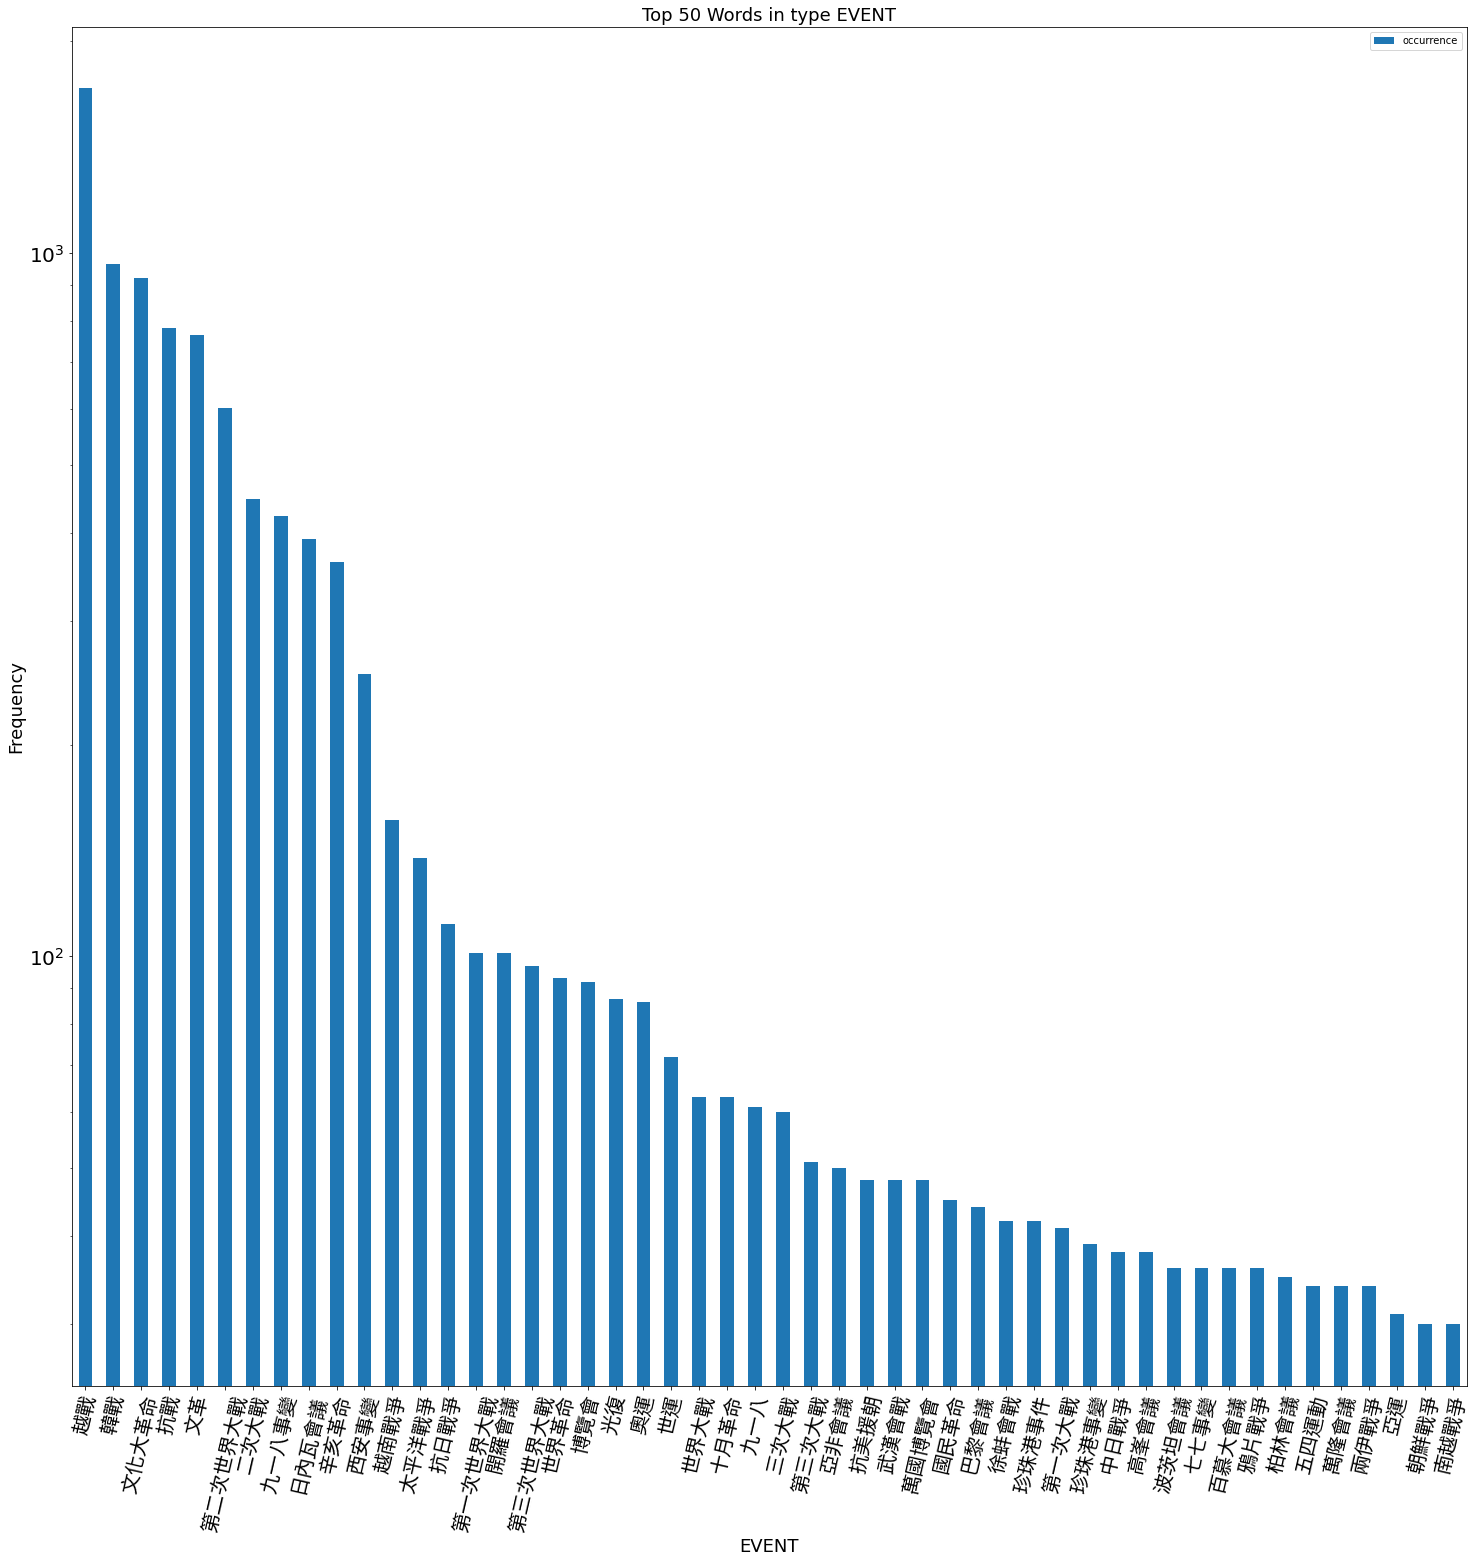

In [17]:
fprop = fm.FontProperties(fname='/content/NotoSansTC-Regular.otf') # from installed path 

# modift length of chart
length = 50

df_sliced = df[0:length]

df_sliced.plot.bar(x=type_to_filter, y="occurrence", rot=77, logy=True)
plt.title('Top 50 Words in type EVENT', fontsize=18)


xticks = list(df_sliced[type_to_filter])
x = [i for i in range(length)]
plt.xticks(x, xticks, fontproperties=fprop, fontsize=20) # rotation ='vertical'
plt.yticks(fontsize = 20, rotation ='horizontal')
plt.xlabel('EVENT', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# plt.figure(figsize=(8, 2))
plt.rcParams["figure.figsize"] = (25,25)
plt.show(block=True)


###Colour change functions for word clouds

In [18]:
def a(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(YlGnBu_9.colors[random.randint(1,8)])  # start from index 1 to exclude the lightest colour 
def b(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(BuPu_9.colors[random.randint(1,8)])
def c(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(YlOrRd_9.colors[random.randint(1,8)])
def d(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(PuBuGn_9.colors[random.randint(1,8)])
def e(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(GnBu_9.colors[random.randint(1,8)]) 
def f(word, font_size, position, orientation, random_state=None, **kwargs): # wordcloud documentation sample
  return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)



###Word Cloud - PERSON

In [19]:
# PERSON
# Selected Type
type_to_filter = "PERSON"
# Selected Filter
filter_inclusion = 'PERSON_list'
filter_replacement = 'PERSON_dict'
        
temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

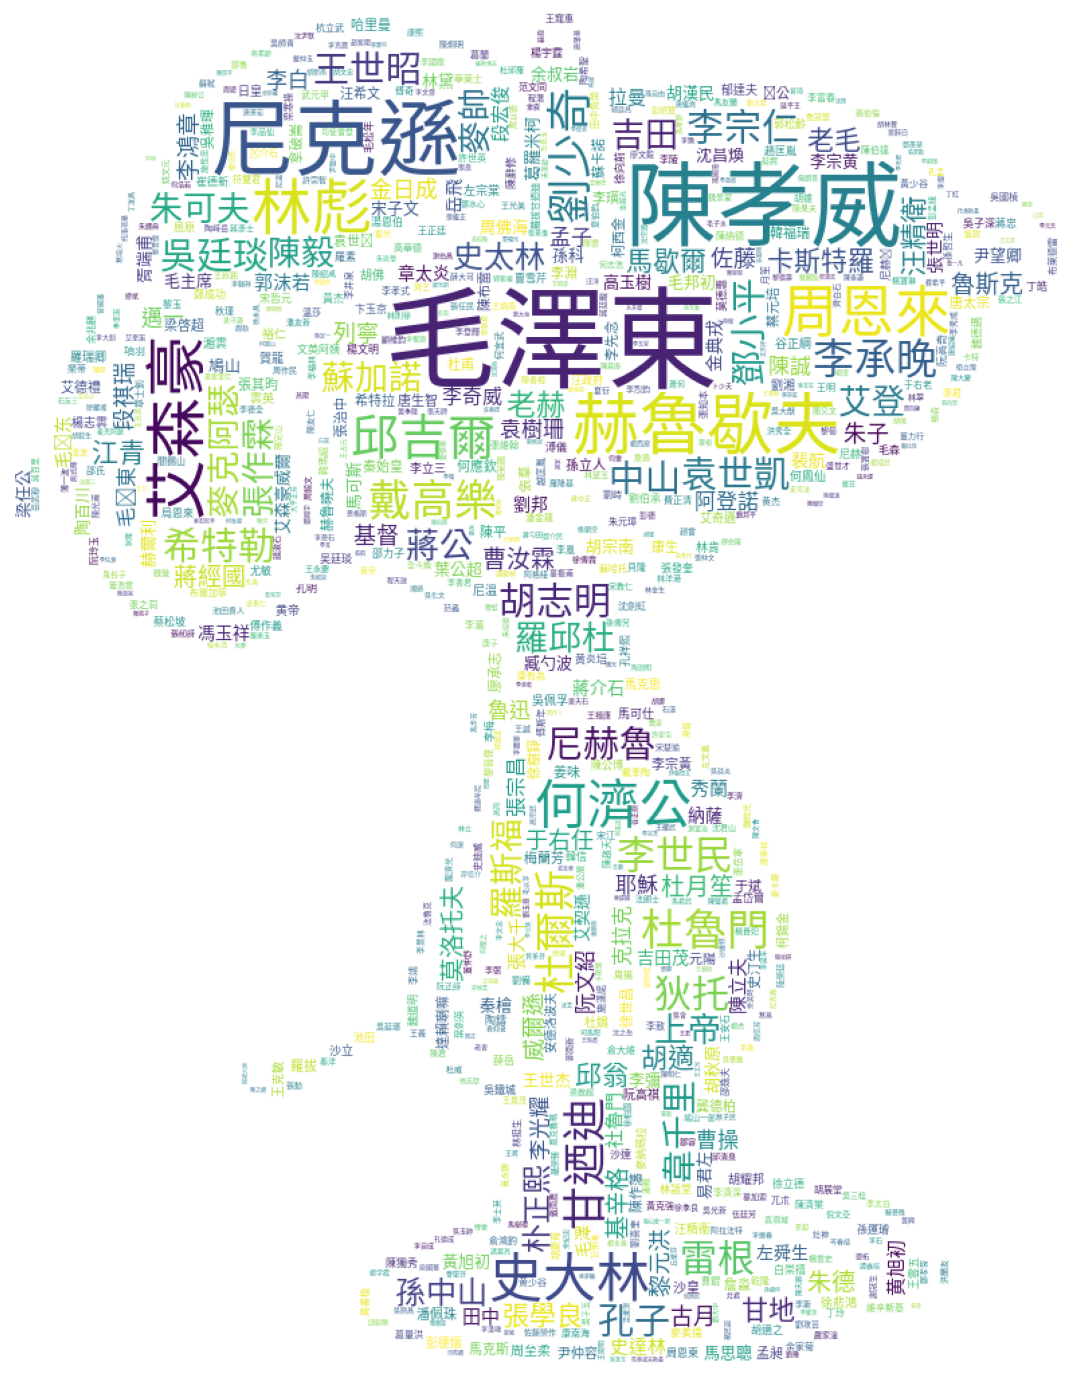

In [20]:
# RE-Organized ver 

font = "/content/NotoSansTC-Regular.otf"

not_snoopy = 'https://dsprojects.lib.cuhk.edu.hk/media/filer_public/42/8d/428df22a-8a12-4a89-8634-1534112eb67a/funnynotsnoopypng.png'


image_ulr = urlretrieve(not_snoopy, "sample.png")
icon = Image.open("sample.png")


mask= Image.new("RGB", icon.size, (1000, 1000, 1000))
mask.paste(icon,icon)
mask = np.array(mask)

wc = WordCloud(font_path = font, background_color = "white", max_words = None, mask = mask, random_state = 1)
wc.generate_from_frequencies(temp_type_gpe_dict)
image_colors = ImageColorGenerator(mask)
plt.axis("off") 
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(wc)



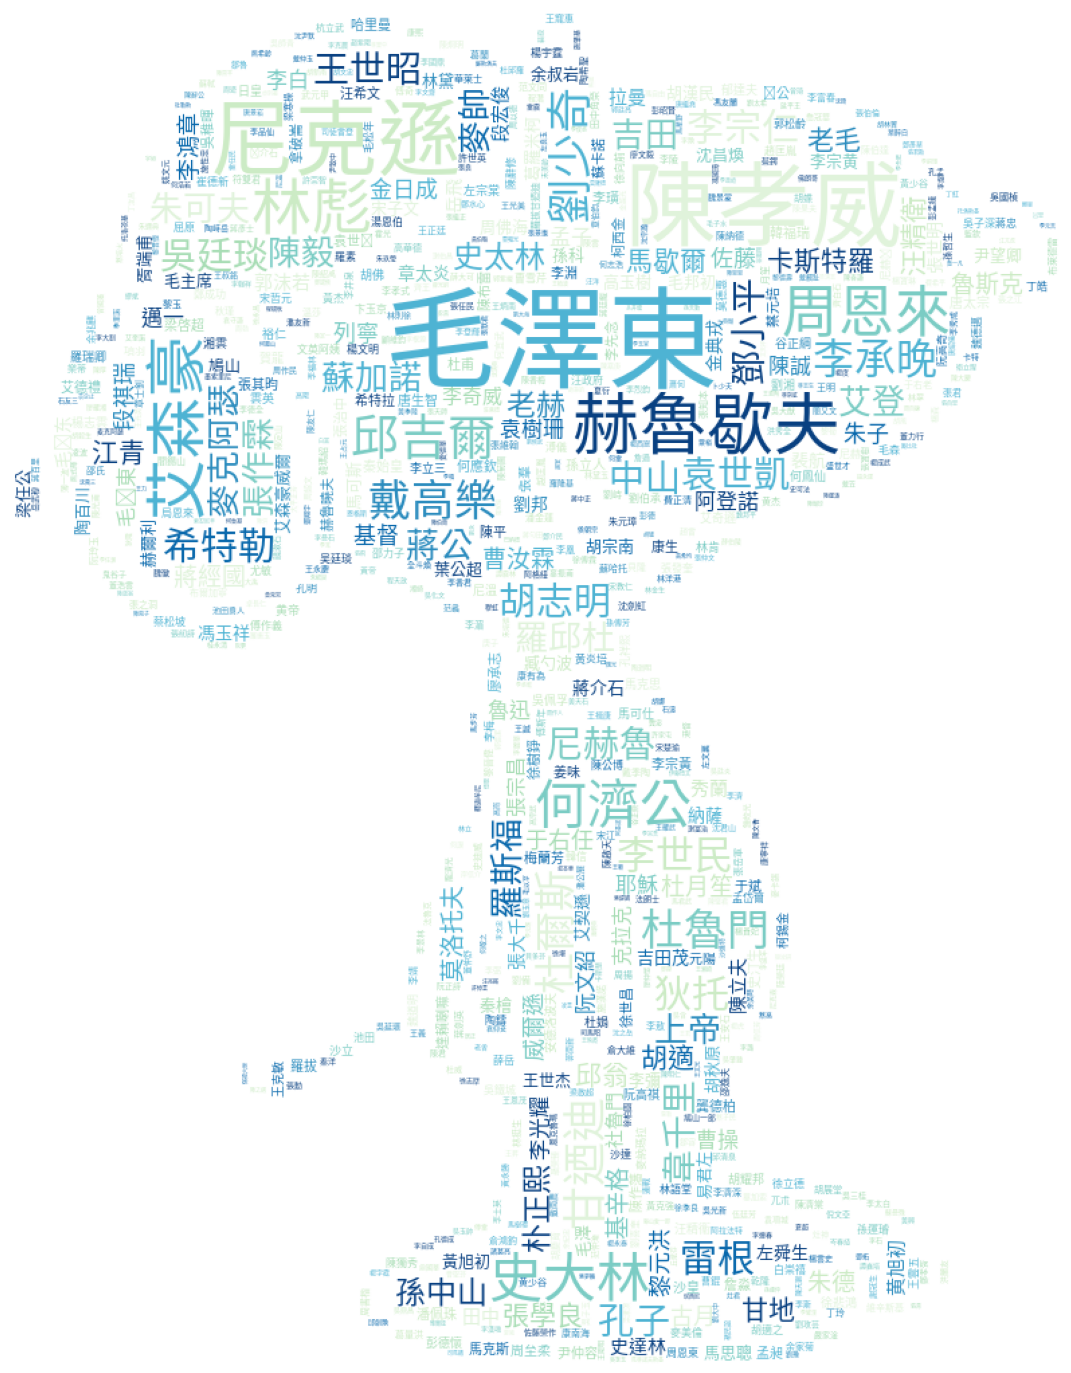

In [21]:
# run to replace the word cloud with randomly selected color scheme
wc.recolor(color_func=random.choice([a, b, c, d, e, f]), random_state=2)  # a, b, c, d, e, f
plt.axis('off')
plt.imshow(wc)

###Word Cloud - ORG

In [22]:
# ORG
# Selected Type
type_to_filter = "ORG"
# Selected Filter
filter_inclusion = 'ORG_list'
filter_replacement = 'ORG_dict'

temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

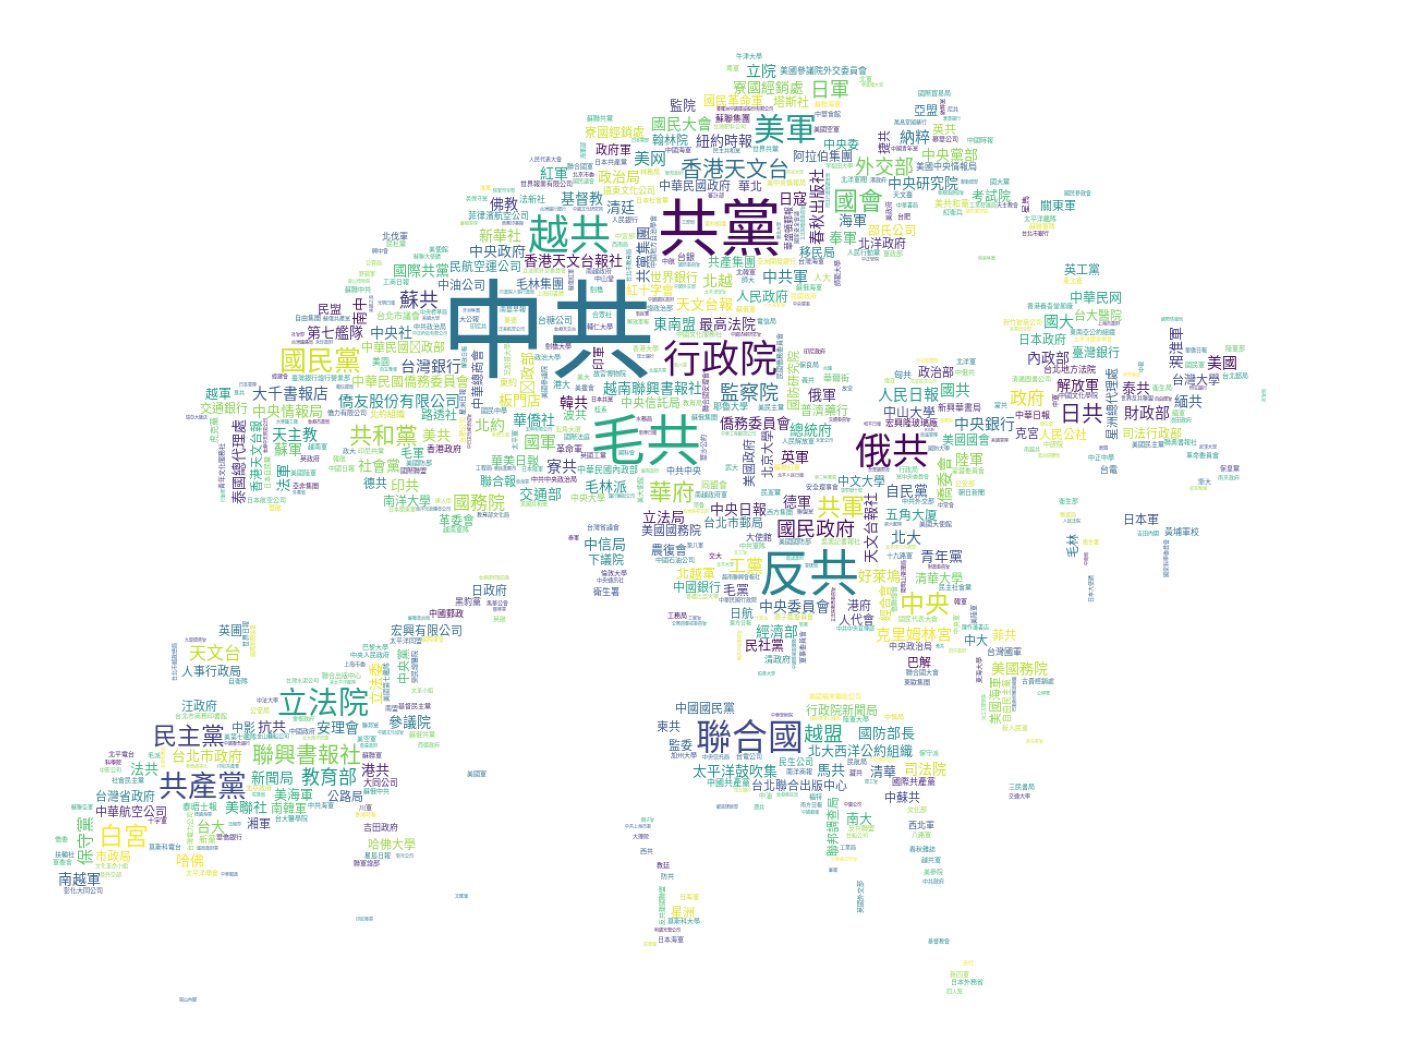

In [23]:
# RE-Organized ver 

font = "/content/NotoSansTC-Regular.otf"

hkpng = 'https://dsprojects.lib.cuhk.edu.hk/media/filer_public/c6/f4/c6f4ddce-43c1-476d-b2ae-91ad1f4ce66b/hkampppppppppppppppppppp.png'


image_ulr = urlretrieve(hkpng, "sample.png")
icon = Image.open("sample.png")

mask= Image.new("RGB", icon.size, (1000, 1000, 1000))
mask.paste(icon,icon)
mask = np.array(mask)

wc = WordCloud(font_path = font, background_color = "white", max_words = None, mask = mask, random_state = 1)
wc.generate_from_frequencies(temp_type_gpe_dict)
image_colors = ImageColorGenerator(mask)
plt.axis("off") 
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(wc)



###Word Cloud - EVENT

In [24]:
# EVENT
# Selected Type
type_to_filter = "EVENT"
# Selected Filter
filter_inclusion = 'EVENT_list'
filter_replacement = 'EVENT_dict'

temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

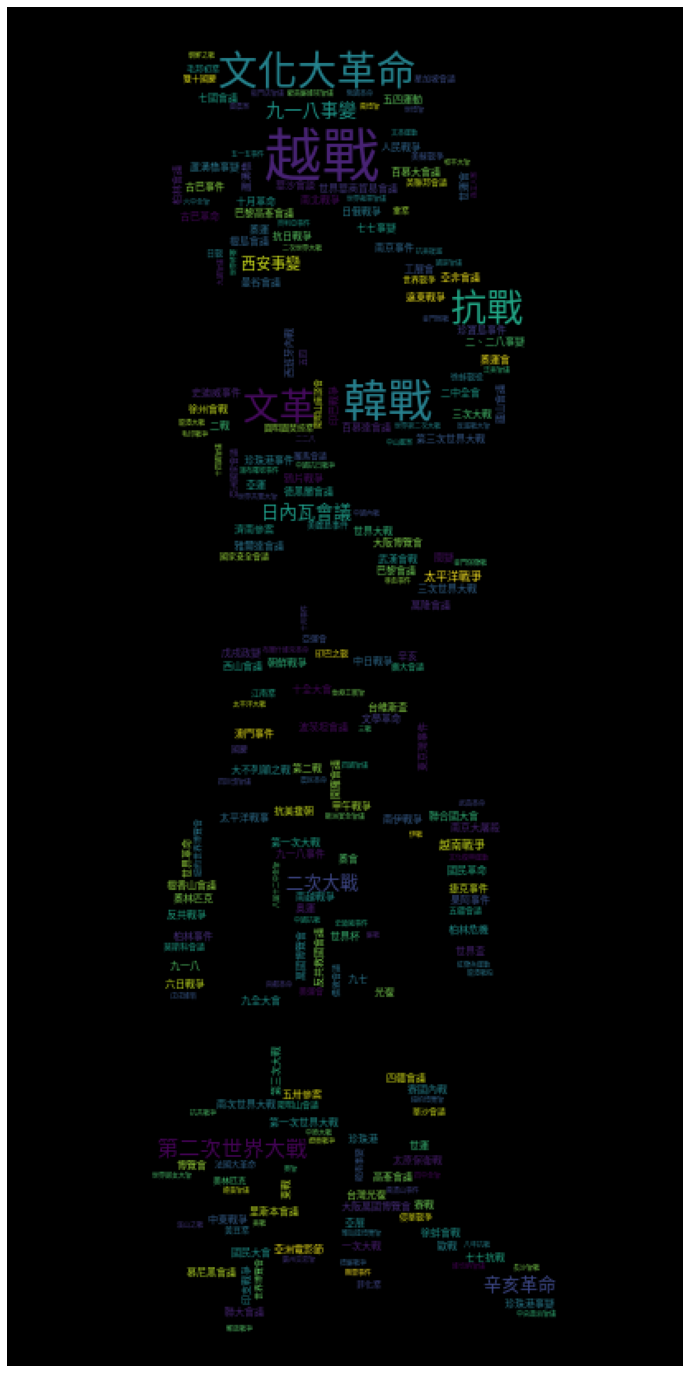

In [25]:
# RE-Organized ver 

font = "/content/NotoSansTC-Regular.otf"

or_logo = 'https://dsprojects.lib.cuhk.edu.hk/media/filer_public/cd/e2/cde206f2-f6a9-414f-9705-06282da807b7/observatoryreview3dpaintertest001.png'

image_ulr = urlretrieve(or_logo, "sample.png")
icon = Image.open("sample.png")

mask= Image.new("RGB", icon.size, (1000, 1000, 1000))
mask.paste(icon,icon)
mask = np.array(mask)

wc = WordCloud(font_path = font, background_color = "black", max_words = None, mask = mask, random_state = 1)
wc.generate_from_frequencies(temp_type_gpe_dict)
image_colors = ImageColorGenerator(mask)
plt.axis("off") 
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(wc)


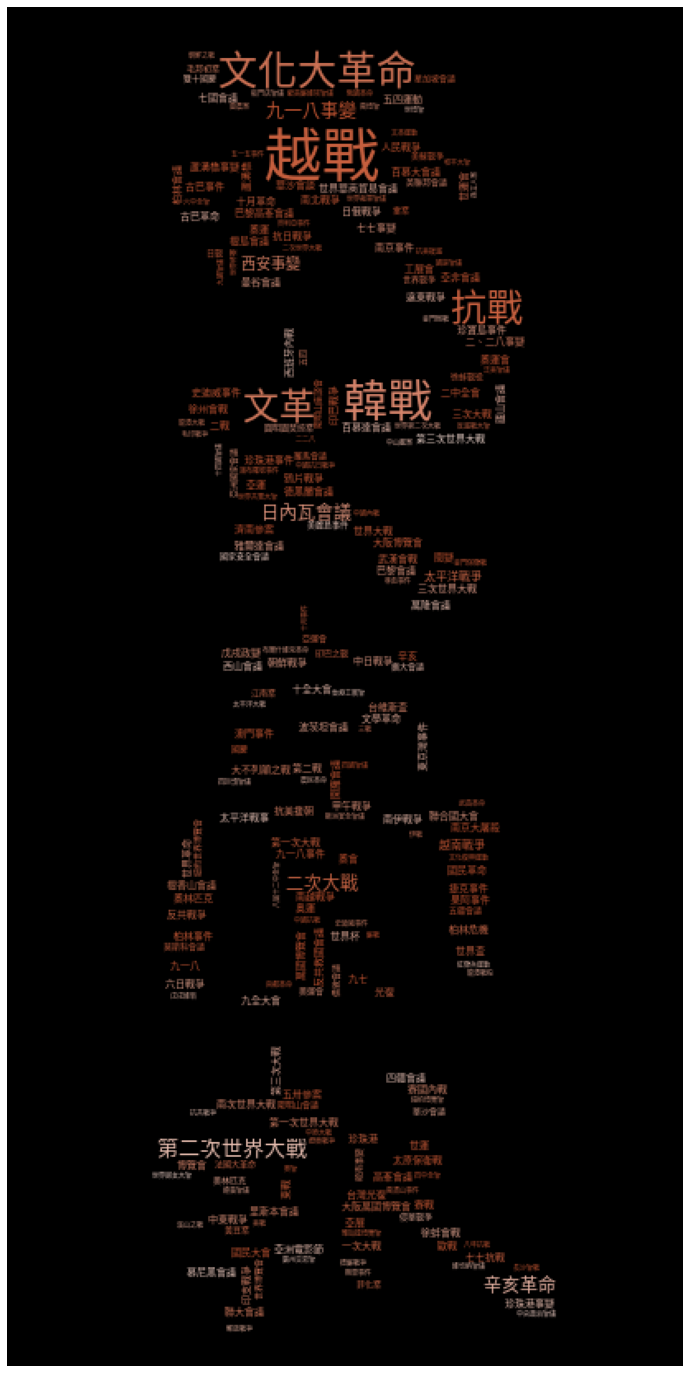

In [26]:
# show the word cloud with original color of the image
wc.recolor(color_func=image_colors, random_state=2)
plt.axis('off')
plt.imshow(wc)